# Predicting 'excessive' pay for SF city workers in 2012
<i>By Diego Ramallo</i> 

See an interactive version of this notebook [here](https://nbviewer.jupyter.org/github/ramalldf/informatics/blob/master/sf_otherpay_predict.ipynb)

<img src="https://dl.dropboxusercontent.com/u/59776078/Lab%20Stuff/python/informatics/informatics/golden-gate-bridge-690346_1280.jpg" alt="Drawing" style="width: 800px;"/> 

Kaggle recently released <a href='https://www.kaggle.com/kaggle/sf-salaries'> salary data</a> for public servants of the city of San Francisco. To put things into context: SF is among the <a href='http://www.economist.com/blogs/graphicdetail/2015/11/daily-chart-0'>most expensive places to live in America.</a> Not surprisingly, the <a href='http://www.census.gov/quickfacts/table/PST045214/06075'> median household income</a> is also among the <a href='http://www.mercurynews.com/business/ci_26312024/santa-clara-county-has-highest-median-household-income'> highest in the nation.</a> The Kaggle dataset reports on the salaries of ~148,000 public employees and provides information under the categories of: <strong>ID, EmployeeName, JobTitle, BasePay, OvertimePay, OtherPay, Benefits, TotalPay, and TotalPayBenefits </strong> for 2011-2014.  

<strong>Otherpay</strong> is a mysterious category since it doesn't qualify as overtime or benefits pay, but it can be SUBSTANTIAL, often dwarfing basepay. Since there are no additional details on what it covers, one could imagine inefficient expenses being listed under this category. And in a city with a <a href='http://www.sfchronicle.com/bayarea/matier-ross/article/Skyrocketing-pension-costs-putting-S-F-in-the-red-6680080.php?t=ac4d4fa181&cmpid=twitter-premium'> large deficit</a> despite a booming economy, it would be useful to see who is more likely to exceed their BasePay with OtherPay. 

Here, <strong>I found that a 3 feature random forest classifier outperforms a logistic regression classifier</strong> in predicting what 2012 SF employees will receive extremely high contributions to their salaries from OtherPay. Considering that the cumulative OtherPay for employees who exceeded this threshold was about <strong>$11 million</strong>, regulating this excess pay could have potentially shave about 10% off the budget deficit for 2012.

<a href='#load'>Loading and preprocessing data</a>
<p></p>
<a href='#split'>Splitting data</a>
<p></p>
<a href='#visualize'>Visualizing data</a>
<p></p>
<a href='#consolidate'>Consolidating data</a>
<p></p>
<a href='#sklearn'>Modeling and training our data</a>
<p></p>
<a href='#validate'>Prediction results and model validation</a>
<p></p>
<a href='#robustness'>Check robustness of model</a>
<p></p>
<a href='#summary'>Summary and conclusions</a>

<a id='load'></a>

## Loading and preprocessing data

In [1]:
import warnings
warnings.filterwarnings('ignore')#Many warnings would pop up that clutter our notebook, this commands disables them
import sqlite3#Used to access database
import pandas as pd#Used to load data as dataframes
import numpy as np#Used for math and array operations
import matplotlib.pyplot as plt#Used for plotting
import seaborn as sns#Also used for plotting, friendly with dataframes

In [2]:
#Create connection to SQLite database
con= sqlite3.connect('sf_salaries.sqlite')

#Use pandas to query database
data= pd.read_sql_query('''SELECT JobTitle, BasePay, OvertimePay, OtherPay, Benefits, TotalPay, TotalPayBenefits, Year FROM Salaries
''',con)

In [3]:
data.head(1)#Preview

,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year
0,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411,0,400184,,567595.43,567595.43,2011


Let's see if length of title affects salary variables, we'll measure the length of titles and append list of lengths to dataframe.


In [4]:
titles= data['JobTitle'].tolist()

titleLen= []
for i in range(0,len(titles)):
    titleLen.append(len(titles[i])-1)#-1 because we have unicode string 'u' in front

lenSeries= pd.Series(titleLen) #Convert list to series
print len(data),len(lenSeries)#Doublecheck that they're the same lengths

148654 148654


In [5]:
data['TitleLen']= lenSeries#Append series to dataframe
data.tail(5)

,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,TitleLen
148649,Custodian,0,0,0,0,0.00,0.00,2014,8
148650,Not provided,Not Provided,Not Provided,Not Provided,Not Provided,0.00,0.00,2014,11
148651,Not provided,Not Provided,Not Provided,Not Provided,Not Provided,0.00,0.00,2014,11
148652,Not provided,Not Provided,Not Provided,Not Provided,Not Provided,0.00,0.00,2014,11
148653,"Counselor, Log Cabin Ranch",0,0,-618.13,0,-618.13,-618.13,2014,25


As you can see above, there are many cells in our table where information is 'Not Provided'. We need to exclude rows that contain this text in order to performs mathematical operations on the Series/columns where they sit. Additionally, closer inspection of the 'data' dataframe shows that the year 2011 <strong>does not include values for Benefits or TotalPayBenefits</strong>. Thus, we'll limit the data to build our model to years 2012-2014 in order to keep our dataset uniform, and in the process also adjust our data types in order to perform additional statistical learning operations on it.

In [6]:
dataClean= data[(data['BasePay'] != 'Not Provided') & (data['Year'] != 2011)]
dataClean.tail(5)

,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,TitleLen
148645,Human Services Technician,0,0,0,0,0.00,0.00,2014,24
148647,Communications Dispatcher 2,0,0,0,0,0.00,0.00,2014,26
148648,Custodian,0,0,0,0,0.00,0.00,2014,8
148649,Custodian,0,0,0,0,0.00,0.00,2014,8
148653,"Counselor, Log Cabin Ranch",0,0,-618.13,0,-618.13,-618.13,2014,25


In [7]:
#Finally, let's check that our numeric sets are all numeric and consistent
dataClean.dtypes

JobTitle             object
BasePay              object
OvertimePay          object
OtherPay             object
Benefits             object
TotalPay            float64
TotalPayBenefits    float64
Year                  int64
TitleLen              int64
dtype: object

In [8]:
#Since they're not all numerical, we'll need to convert the remaining ones (BasePay requires special conversion, see next line)
dataClean['OvertimePay']= dataClean['OvertimePay'].astype(np.float64)
dataClean['OtherPay']= dataClean['OtherPay'].astype(np.float64)
dataClean['Benefits']= dataClean['Benefits'].astype(np.float64)
dataClean['TotalPay']= dataClean['TotalPay'].astype(np.float64)
dataClean['Year']= dataClean['Year'].astype(np.float64)

In [9]:
#BasePay and TitleLen do not get converted to the right datatype using the above operations, we need special conversion operations:
dataClean['BasePay'] = dataClean['BasePay'].convert_objects(convert_numeric=True)

In [10]:
dataClean.dtypes

JobTitle             object
BasePay             float64
OvertimePay         float64
OtherPay            float64
Benefits            float64
TotalPay            float64
TotalPayBenefits    float64
Year                float64
TitleLen              int64
dtype: object

Now that the data types are all numerical, we can proceed with model building. Since we have three years' worth of data, let's use the first year, 2012, to train our data. We can then begin to apply this model to additional years if we choose to do so later.

<a id='split'></a>

## Splitting data

In [11]:
clean2012= dataClean[dataClean['Year'] == 2012]#Filter out non-2012 data.
clean2012= clean2012.drop(['Year'], axis= 1)#Since we know it is from 2012, we don't need a 2012 column anymore.

In [12]:
from sklearn.cross_validation import train_test_split
train2012, test2012 = train_test_split(clean2012, test_size = 0.2, random_state= 42)
train2012.tail(3)

,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,TitleLen
47443,Health Program Coordinator 3,92820.12,0.00,0.00,37676.27,92820.12,130496.39,27
37019,Police Officer 3,122024.57,47737.88,24917.73,35819.39,194680.18,230499.57,15
51954,Chief Clerk,76719.20,0.00,0.00,33687.18,76719.20,110406.38,10


<a id='visualize'></a>

## Visualizing our data

Using a pairplot, let's observe the relationship between OtherPay and the numerical features that are <strong>NOT</strong> sums of any of the other component features (eg. TotalPay and TotalPayBenefits). We'll then generate a <strong>correlation matrix</strong> between our features and the OtherPay response to quantitate the strength of their relationship.

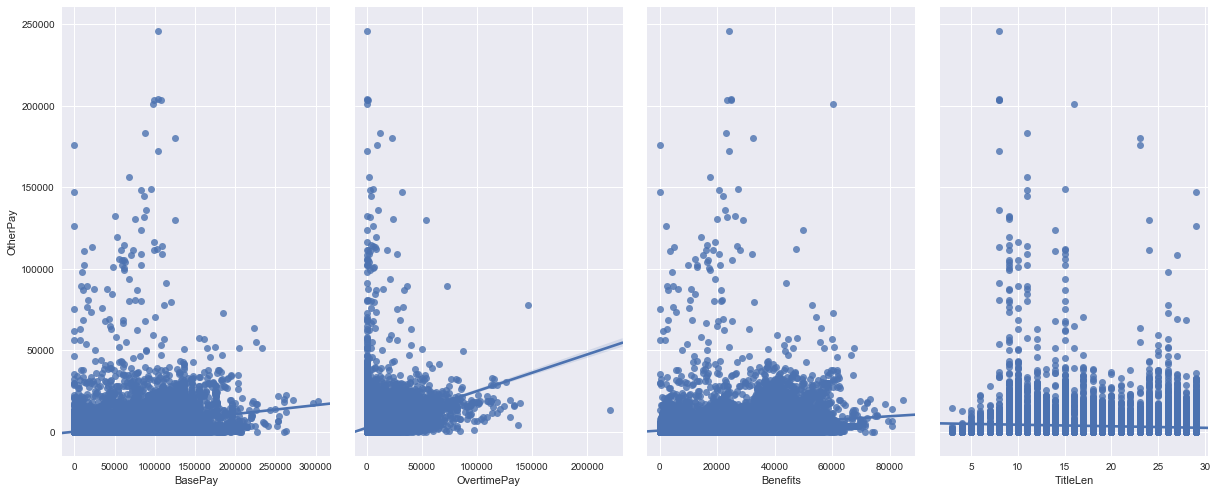

In [13]:
%matplotlib inline
sns.pairplot(train2012, 
             x_vars= ['BasePay','OvertimePay','Benefits','TitleLen'], 
             y_vars= 'OtherPay', size= 7, aspect= 0.6, 
             kind= 'reg')

In [14]:
train2012[['BasePay','OvertimePay','Benefits','TitleLen','OtherPay']].corr()#Correlation matrix for features and response

,BasePay,OvertimePay,Benefits,TitleLen,OtherPay
BasePay,1.000000,0.275653,0.911973,-0.011340,0.279908
OvertimePay,0.275653,1.000000,0.272858,-0.019485,0.314861
Benefits,0.911973,0.272858,1.000000,0.013372,0.213241
TitleLen,-0.011340,-0.019485,0.013372,1.000000,-0.077152
OtherPay,0.279908,0.314861,0.213241,-0.077152,1.000000


Our plots are quite noisy, but do show some weak <strong>linear relationships</strong> between the features and the response. It is also clear that there is a subset of employees that are making more money from OtherPay than from BasePay (what one assumes should be the largest contributor to their salary, left panel). The correlation matrix validates that aside from BasePay and Benefits, most features only have a weak to moderate correlation with OtherPay and one another. 

<a id='consolidate'></a>

## Consolidating  data

A large fraction of the employees receive OtherPay, but we're interested in those that may receive <i>excessive</i> OtherPay payments. Thus, if we set an OtherPay compensation threshold for employees with OtherPays that are approximately <u>(> 90%)</u> as large as their BasePay, we can make a dummy variable that returns a <strong>categorical response</strong>. In this case, 1 if it is above the 90% threshold, and 0 if it is below it.


In [15]:
basePayTrain= np.array(train2012['BasePay'])#Turn Series into list to speed up our for loop
otherPayTrain= np.array(train2012['OtherPay'])
excessThresh= []; #ExcessThresh= otherPay > 0.9*basePay, equals 1 or 0; exValue= OtherPay quantity
for i in range(0,len(basePayTrain)):
    
    if 0.9*basePayTrain[i] <= otherPayTrain[i]:#Choosing OtherPay values greater than 90% of BasePay
        excessThresh.append(1)
    else:
        excessThresh.append(0)
        
#Let's doublecheck that excess only has 0 or 1 values:
np.unique(excessThresh)

array([0, 1])

Excellent, now let's visualize what data excessThresh covers (OtherPay > 90% of BasePay) plotted over our original BasePay vs OtherPay plot. We'll have to filter our BasePayTrain and OtherPayTrain variables to remove all the zeros in our data.

In [16]:
otherPayTrainThresh= np.array(excessThresh)*otherPayTrain#Masking OtherPay with results from excess
otherPayTrainThreshNo0= otherPayTrainThresh[otherPayTrainThresh!=0]#Remove all rows with zero

basePayTrainThreshNo0= basePayTrain[otherPayTrainThresh!=0]#Remove all rows where otherPayTrainThresh = 0

Excellent. Now let's plot BasePay vs OtherPay with an option to hover over each point that exceeded our threshold to see what positions these public employees hold using the Bokeh library.

In [17]:
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.models import NumeralTickFormatter

#Indicates that plot will show up in next cell
output_notebook()

#We'll now make the source for the info on our hover
source= ColumnDataSource(data= dict(
        x= train2012['BasePay'],
        y= train2012['OtherPay'],
        title= train2012['JobTitle']))

hover= HoverTool(tooltips= [("Job Title", "@title")])

#Initialize figure
p = figure(plot_width=900, plot_height=400, tools=[hover, 'wheel_zoom', 'pan', 'reset'], 
           title= "SF Employees whose OtherPay exceeds 90% of BasePay", title_text_font_size='18pt')

#First plot the thresholded data in orange
p.circle(basePayTrainThreshNo0,otherPayTrainThreshNo0, line_color= 'orangered', fill_alpha= 0, 
                           line_width= 4, size= 5, legend = 'Sample subset above threshold')

#Plot total dataset in blue
p.circle(train2012['BasePay'],train2012['OtherPay'], size=5, source= source, legend = 'Training sample', color= '#17a9e8' )

#Modify style
p.xaxis[0].formatter = NumeralTickFormatter(format="0")
p.yaxis[0].formatter = NumeralTickFormatter(format="0")

p.xaxis.axis_label = "BasePay ($)"
p.yaxis.axis_label = "OtherPay ($)"

p.title_text_font_style = "bold"

show(p)

Loading BokehJS ...

552 employees earn OtherPay that is greater than or equal to 90% of their BasePay, and cumulatively, these employees OtherPay equals about 11 million dollars. To put that into context, SF spent <a href='http://www.nytimes.com/2016/02/05/us/super-bowl-50-further-divides-san-francisco.html?_r=0'>$5 million</a> on putting the Superbowl together in 2016, and as you may recall, this only covers our training set. From the plot above we can also see that they are generally employees who fall below the center of the distribution in our training set. Now let's add the categorial results from excess to our dataframe as <strong>'ThreshPay'</strong>.

In [18]:
train2012['ThreshPay']= excessThresh
train2012.tail(3)

,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,TitleLen,ThreshPay
47443,Health Program Coordinator 3,92820.12,0.00,0.00,37676.27,92820.12,130496.39,27,0
37019,Police Officer 3,122024.57,47737.88,24917.73,35819.39,194680.18,230499.57,15,0
51954,Chief Clerk,76719.20,0.00,0.00,33687.18,76719.20,110406.38,10,0


Finally, we'll do the <strong>same for our testing dataset</strong>. Once this is finished we can train and test our model!

In [19]:
basePayTest= np.array(test2012['BasePay'])#Turn Series into list to speed up our for loop
otherPayTest= np.array(test2012['OtherPay'])
excessTestThresh= [];#Excess= 1 or 0; exValue= OtherPay quantity
for i in range(0,len(basePayTest)):
    
    if 0.9*basePayTest[i] <= otherPayTest[i]:#Choosing OtherPay values greater than 90% of BasePay
        excessTestThresh.append(1)
    else:
        excessTestThresh.append(0)
test2012['ThreshPay']= excessTestThresh#Adding list as a column to test2012 testing dataset

<a id='sklearn'></a>

## Modeling and training our data

Now that we have consolidated our responses into 'ThreshPay' and added it to our dataset, we can make and train our model, and finally use it to make predictions on the test dataset. Let's begin by organizing our features and responses (x and y, respectively) into separate dataframes for both the training and testing sets.

In [20]:
xTrain2012= train2012[['BasePay','OvertimePay','Benefits','TitleLen']]
yTrain2012= train2012[['ThreshPay']]

xTest2012= test2012[['BasePay','OvertimePay','Benefits','TitleLen']]
yTest2012= test2012[['ThreshPay']]

In [21]:
xTrain2012.tail(1)#Checking that we have the appropriate features

,BasePay,OvertimePay,Benefits,TitleLen
51954,76719.2,0.0,33687.18,10


Since our feature set, xTrain2012, is relatively small, and we saw some linear relationships between our features and OtherPay, let's assume we can model our relationship with a linear model, using <strong>logistic regression</strong> and <strong>random forests</strong> methods, and <i>with and without</i> TitleLen (which in general has the weakest correlation coefficients). 

Using the Scikit-Learn Package, we'll need to create objects for each of the four conditions, train/fit the models using our training data, and finally make predictions using features from our testing data. One final thing to point out: since events that exceed the 90% threshold are rare (552 out of ~15000), our classes are <strong>imabalanced</strong>. Thus, performing classification using logistic regression or random forests will be biased towards the events below the threshold. Luckily, both logistic regression and random forests have arguments that weigh the classes appropriately to account for this.

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

#Initialize model objects for all four situations, since 
logmod= LogisticRegression(class_weight = 'balanced', random_state= 42)#Include all four features
logmod2= LogisticRegression(class_weight = 'balanced', random_state= 42)#All features but TitleLen
# forest= RandomForestClassifier(min_samples_leaf = 10, class_weight = 'balanced', random_state= 42)#Include all four features
# forest2= RandomForestClassifier(min_samples_leaf = 10, class_weight = 'balanced', random_state= 42)#All features but TitleLen

forest= RandomForestClassifier(n_estimators= 100, class_weight = 'balanced', min_samples_leaf= 10, random_state= 42)#Include all four features
forest2= RandomForestClassifier(n_estimators= 100, class_weight = 'balanced', min_samples_leaf= 10, random_state= 42)#All features but TitleLen

In [90]:
xTrain2012.shape

(29412, 4)

In [91]:
#Train the models 
logfit= logmod.fit(xTrain2012,yTrain2012)
logfit2= logmod2.fit(xTrain2012[['BasePay','OvertimePay','Benefits']],yTrain2012)
forfit= forest.fit(xTrain2012,yTrain2012)
forfit2= forest2.fit(xTrain2012[['BasePay','OvertimePay','Benefits']],yTrain2012)

//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [92]:
#Make predictions using the test datasets
logpred= logfit.predict(xTest2012)#Prediction for 4 features
logpred2= logfit2.predict(xTest2012[['BasePay','OvertimePay','Benefits']])#Prediction for 3 features
forpred= forfit.predict(xTest2012)
forpred2= forfit2.predict(xTest2012[['BasePay','OvertimePay','Benefits']])

<a id='validate'></a>

## Prediction results and model validation

Now that we have predictions generated by our four models, we can generate metrics that will tell us about their accuracy. First, we'll measure an accuracy score between 0 and 1 for our predictions compared to the true results.

In [93]:
#Use metrics to measure the accuracy of our predictions compared to the true results in yTest2012
print '4-Feat. Log. Reg. model accuracy: ', accuracy_score(yTest2012,logpred)#Accuracy score for 4 features
print '3-Feat. Log. Reg. model accuracy: ', accuracy_score(yTest2012,logpred2)#Score for 3 features
print '4-Feat. Random Forest model accuracy: ', accuracy_score(yTest2012,forpred)
print '3-Feat. Random Forest model accuracy: ', accuracy_score(yTest2012,forpred2)

4-Feat. Log. Reg. model accuracy:  0.765705738374
3-Feat. Log. Reg. model accuracy:  0.766521620887
4-Feat. Random Forest model accuracy:  0.987761762306
3-Feat. Random Forest model accuracy:  0.984906173511


The accuracy scores are above random for logistic regression, but extremely high for the random forest models. It may help to visualize differences in their performance with a <strong>confusion matrix</strong> which will give us statistics on True positives, True negatives, False positives, and False negatives. This way we can determine how sensitive the models are to detecting both classes.

In [94]:
#Second line normalizes the confusion matrices to make it easier to compare between models.

cmLog= confusion_matrix(yTest2012,logpred)#Confusion matrix for logistic regression model (4 features)
cmLogNorm = cmLog.astype('float') / cmLog.sum(axis=1)[:, np.newaxis]#Normalized model

cmLog2= confusion_matrix(yTest2012,logpred2)
cmLog2Norm = cmLog2.astype('float') / cmLog2.sum(axis=1)[:, np.newaxis]#Fraction of cell when matrix summed along rows

cmForpred= confusion_matrix(yTest2012,forpred)
cmForpredNorm = cmForpred.astype('float') / cmForpred.sum(axis=1)[:, np.newaxis]

cmForpred2= confusion_matrix(yTest2012,forpred2)
cmForpred2Norm = cmForpred2.astype('float') / cmForpred2.sum(axis=1)[:, np.newaxis]

The confusion matrix returns a 2x2 matrix. Now let's visualize the four matrices to see if we can identify the most useful models.

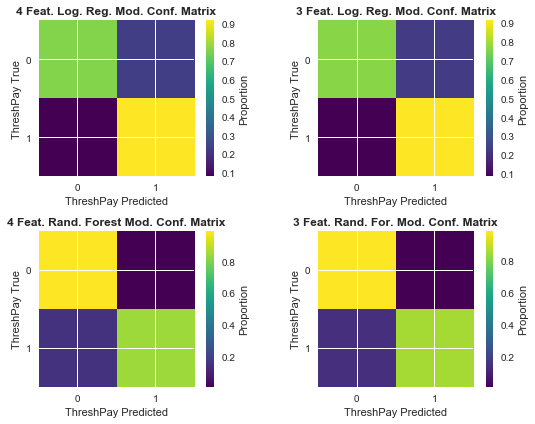

In [95]:
fig,ax= plt.subplots(1,1, figsize=(8,6))

plt.subplot(2,2,1)
plt.imshow(cmLogNorm, interpolation='nearest', cmap='viridis')
plt.ylabel('ThreshPay True')
plt.xlabel('ThreshPay Predicted')
plt.xticks(np.arange(0,2))
plt.yticks(np.arange(0,2))
plt.colorbar(label='Proportion')
plt.title('4 Feat. Log. Reg. Mod. Conf. Matrix', fontweight= 'bold')

plt.subplot(2,2,2)
plt.imshow(cmLog2Norm, interpolation='nearest', cmap='viridis')
plt.ylabel('ThreshPay True')
plt.xlabel('ThreshPay Predicted')
plt.xticks(np.arange(0,2))
plt.yticks(np.arange(0,2))
plt.colorbar(label='Proportion')
plt.title('3 Feat. Log. Reg. Mod. Conf. Matrix', fontweight= 'bold')


plt.subplot(2,2,3)
plt.imshow(cmForpredNorm, interpolation='nearest', cmap='viridis')
plt.ylabel('ThreshPay True')
plt.xlabel('ThreshPay Predicted')
plt.xticks(np.arange(0,2))
plt.yticks(np.arange(0,2))
plt.colorbar(label='Proportion')
plt.title('4 Feat. Rand. Forest Mod. Conf. Matrix', fontweight= 'bold' )

plt.subplot(2,2,4)
plt.imshow(cmForpred2Norm, interpolation='nearest', cmap='viridis')
plt.ylabel('ThreshPay True')
plt.xlabel('ThreshPay Predicted')
plt.xticks(np.arange(0,2))
plt.yticks(np.arange(0,2))
plt.colorbar(label='Proportion')
plt.title('3 Feat. Rand. For. Mod. Conf. Matrix', fontweight= 'bold')
plt.tight_layout()

In [96]:
from sklearn import metrics

print 'Here are the logistic reg.  method metrics'
print metrics.classification_report(yTest2012, logpred2)

print 'Here are the random forest method metrics'
print metrics.classification_report(yTest2012, forpred2)

Here are the logistic reg.  method metrics
             precision    recall  f1-score   support

          0       1.00      0.76      0.87      7230
          1       0.06      0.91      0.12       124

avg / total       0.98      0.77      0.85      7354

Here are the random forest method metrics
             precision    recall  f1-score   support

          0       1.00      0.99      0.99      7230
          1       0.53      0.85      0.66       124

avg / total       0.99      0.98      0.99      7354



To remind you, ThreshPay response is binary: above (1) or below (0) the BasePay threshold. The confusion matrices are a 2x2 grid with our Predicted ThreshPay values on the x-axis, and True ThreshPay values from the test set on the y-axis. <strong>Thus, accurate predictions sit diagonally while inaccurate predictions sit off-diagonally</strong>. The colorbar describes the normalized, cumulative probabilities of each of four outcomes for each model.
<p></p>
The random forests models outperformed the logistic regression models for both classes. Interestingly enough, since the bottom right quadrants are guessed correctly more often for logistic regression, but poorly for the zero class (top left quadrant), it indicates that the logistic regression models guess 1 more frequently in general, but since the 0 class is more common, it's overall accuracy suffers because of it. 

By comparison, the random forest models do the opposite and are more conservative with the their class 1 guesses and tend to have a much higher accuracy because of it. One other thing we can see is that removing the 'TitleLen' feature we engineered improves our accuracy in both the logistic regression and random forest examples. 

Given that <strong>three features</strong> gives more accurate predictions than four, should we choose to use logistic regression or the random forest model as we move forward? The answer usually depends on the decision to <strong>predict</strong> responses or to <strong>infer</strong> the intricacies of the model's components more thoroughly. Since I'm more interested in prediction for the time being, I'll mostly be concerned with the model's accuracy, and random forests would make more sense. However, in this situation a we have an additional concern. 

Based on the precision-recall scores, we know that a)logistic regression is excellent at detecting true positives (recall ~ 91%), but not great at detecting true negatives (recall ~ 76%). Meanwhile, b) random forests is good at detecting true negatives at a recall of ~ 99%, but true positives at only 75%. Let's think back to practical terms, and consider that the classes are imbalanced favoring the negatives (7230 vs 124). If we'd like to minimize allocated resources to investigate excessive compensation (positives), we can see that choosing logistic regression means we'd incorrectly have to investigate 1735 (7230-(7230*0.76)) individuals, and miss 12 positives (124-(124*0.91)). Meanwhile, with random forests, we'd miss out on correctly identifying 31 individuals (124-(124 * 0.75)), but wouldn't have to investigate very many extra false positives since our recall for negatives was 100%. It would be much cheaper to miss investigating 30 individuals than to unecessarily investigate 1700 individuals with logistic regression. Thus, random forests makes sense here too.

if we decide that SF should spend resources looking into the positives that means that we'd have to look at 1000 false positives with a), but only miss out on 20 this means that if we chose a), we may have to  


We can perform one final check on the performance of our models with a receiver operating characteristic (ROC) curve that plots the true positive rate (<strong>TPR</strong>) against the false positive rate (<strong>FPR</strong>).

## Check robustness of model

In order to generate the plot, we need to calculate the <strong>predicted probabilities</strong> (calculated probabilities used to determine predicted responses) for each model. Using the predicted probabilities, we can generate the TPR ('Sensitivity') and FPR (1-'Specificity') values. The larger the Area Under the Curve (<strong>AUC</strong>), the more accurate our model. Since three feature models performed better, we'll visualize the three feature models for both logistic regression and random forests.

In [30]:
#Now I'll calculate the predicted probabilities for each model using our fit object, and our test 3 feature set
log2predprob= logfit2.predict_proba(np.array(xTest2012[['BasePay','OvertimePay','Benefits']]))
for2predprob= forfit2.predict_proba(np.array(xTest2012[['BasePay','OvertimePay','Benefits']]))

In [31]:
#Calculate the FPR, TPR, and AUC for each model using the True test response (yTest2012) and model predicted probabilities
from sklearn.metrics import roc_curve, roc_auc_score

logreg2Fpr, logreg2Tpr, _= roc_curve(yTest2012,log2predprob[:,1])
forpred2Fpr, forpred2Tpr, _ = roc_curve(yTest2012,for2predprob[:,1])

logreg2Auc= roc_auc_score(yTest2012,log2predprob[:,1])
forpred2Auc= roc_auc_score(yTest2012,for2predprob[:,1])

Log. Reg. AUC:  0.91670570651
Rand. For. AUC:  0.970132847008


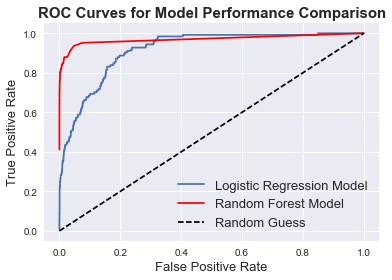

In [32]:
#Create plot objects and plot TPR vs FPR, add legends and adjust legend position
plt.subplot(1,1,1)
logreg2RocPlot,= plt.plot(logreg2Fpr,logreg2Tpr, label='3 Feat. Log. Reg. Model')
for2RocPlot,= plt.plot(forpred2Fpr,forpred2Tpr, label= '3 Feat. Rand. For. Model', color= 'red')
guessPlot,= plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize= 13)
plt.ylabel('True Positive Rate', fontsize= 13)
plt.title('ROC Curves for Model Performance Comparison', size= 15, fontweight= 'bold')
plt.legend([logreg2RocPlot,for2RocPlot, guessPlot], ['Logistic Regression Model','Random Forest Model', 'Random Guess'], loc=4, fontsize= 13)

print 'Log. Reg. AUC: ', logreg2Auc
print 'Rand. For. AUC: ', forpred2Auc

<a id= 'summary'></a>

## Summary and conclusions

In this notebook, we used supervised machine learning to build statistical models that predict which employees receive OtherPay compensation that is comparable in magnitude to their BasePay (ie. 'extremely high compensation'). Unlike the other components that make up total salaries, OtherPay is vague and if unregulated, could leave room for inefficiencies and/or corruption. Thus, a model that can accurately predict which public workers will exceed a threshold could be useful for internal auditing of the city of San Francisco. 

We were able to access a database and load data on the salary components of public servants in SF and focused on data from 2012. After cleaning and standardizing the dataset, we developed dummy target variables to categorize our results into above or below the threshold. After training our models for three and four-feature versions of logistic regression and random forest models, we discovered that random forest models were substantially more accurate than the logistic regression models and that reducing our training sets to three feature models from four were slightly more accurate than the four feature predictions. <i>Thus, our preferred model for threshold predictions was the <strong>three feature random forest model</strong></i>.

Since not all employees apparently receive BasePay compensation, future work could include adding a lower-bound threshold to not include those employees. We could also apply our methods to predict thresholds in sequential years, and map the dynamic range of our prediction accuracy by varying the threshold level. 